In [12]:
!pip install opencv-python numpy matplotlib scikit-learn scikit-image

## Carga y procesamiento de imagenes

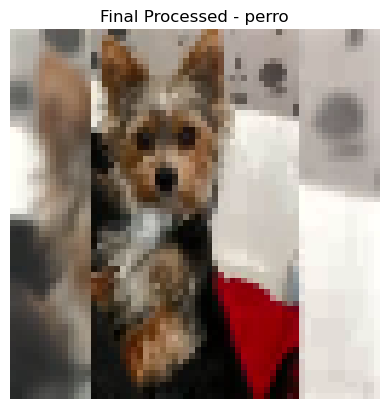

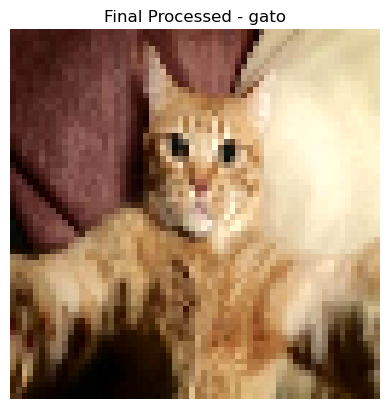

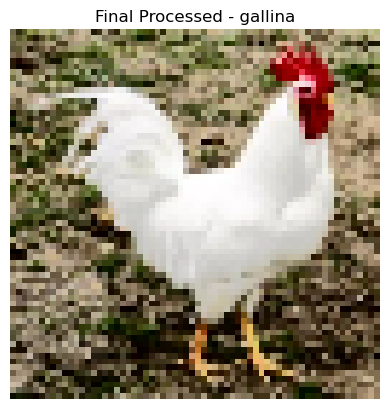

In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

def remove_noise(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

def normalize_size(image, size=(64, 64)):
    return cv2.resize(image, size)

def adjust_contrast(image):
    img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

dataset_path = 'dataset'
categories = ['perro', 'gato', 'gallina']

all_images = {}
preprocessed_images = {}

for category in categories:
    folder_path = os.path.join(dataset_path, category)
    images = load_images_from_folder(folder_path)
    
    preprocessed = []
    for img in images:
        img_noisy_removed = remove_noise(img)
        img_normalized = normalize_size(img_noisy_removed)
        img_contrast_adjusted = adjust_contrast(img_normalized)
        preprocessed.append(img_contrast_adjusted)
    
    all_images[category] = images
    preprocessed_images[category] = preprocessed

for category in categories:
    plt.figure()
    plt.title(f'Final Processed - {category}')
    plt.imshow(cv2.cvtColor(preprocessed_images[category][0], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


## Extracción de caracteristicas

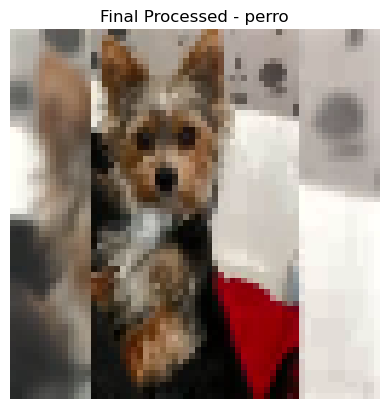

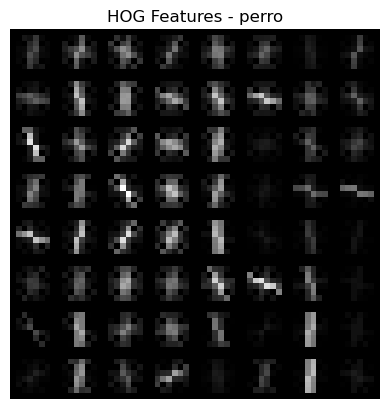

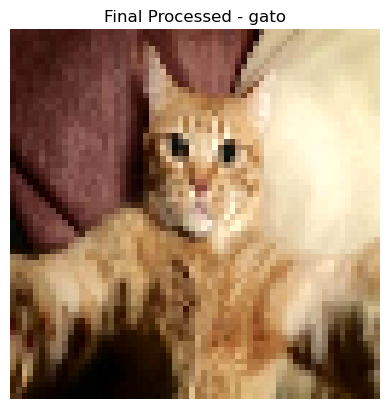

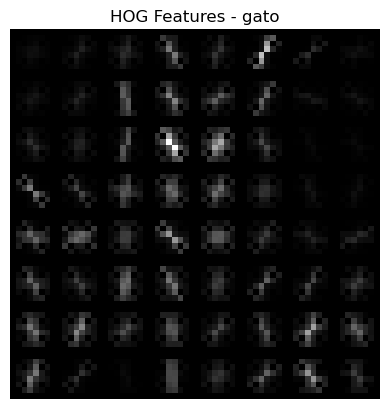

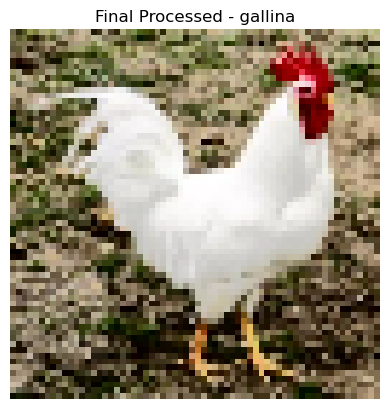

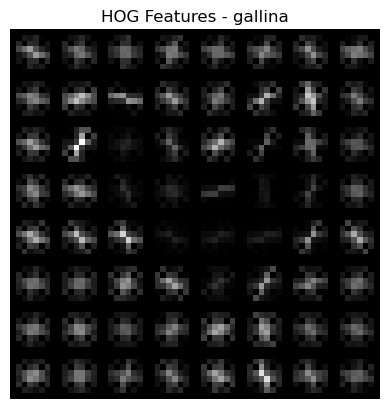

Extracción de características completada.


In [9]:
from skimage.feature import hog

def extract_hog_features(images):
    hog_features = []
    for img in images:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        features, hog_image = hog(gray_img, orientations=8, pixels_per_cell=(8, 8),
                                  cells_per_block=(2, 2), visualize=True)
        hog_features.append(features)
    return np.array(hog_features)

hog_features_all = {}

for category in categories:
    hog_features = extract_hog_features(preprocessed_images[category])
    hog_features_all[category] = hog_features

for category in categories:
    plt.figure()
    plt.title(f'Final Processed - {category}')
    plt.imshow(cv2.cvtColor(preprocessed_images[category][0], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    
    gray_img = cv2.cvtColor(preprocessed_images[category][0], cv2.COLOR_BGR2GRAY)
    features, hog_image = hog(gray_img, orientations=8, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), visualize=True)
    plt.figure()
    plt.title(f'HOG Features - {category}')
    plt.imshow(hog_image, cmap='gray')
    plt.axis('off')
    plt.show()

all_hog_features = np.concatenate(list(hog_features_all.values()), axis=0)

all_labels = np.concatenate([[category] * len(hog_features_all[category]) for category in categories])

## Selección de caracteristicas

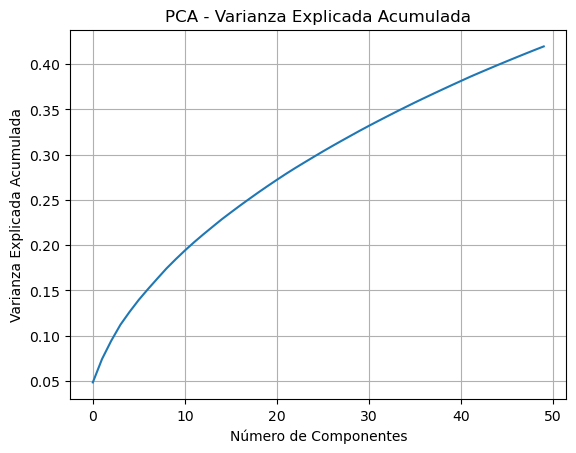

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
reduced_features = pca.fit_transform(all_hog_features)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('PCA - Varianza Explicada Acumulada')
plt.grid()
plt.show()

## Modelado

C:\Users\samhe\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.048577756890745706
Visualizing clusters for category: perro


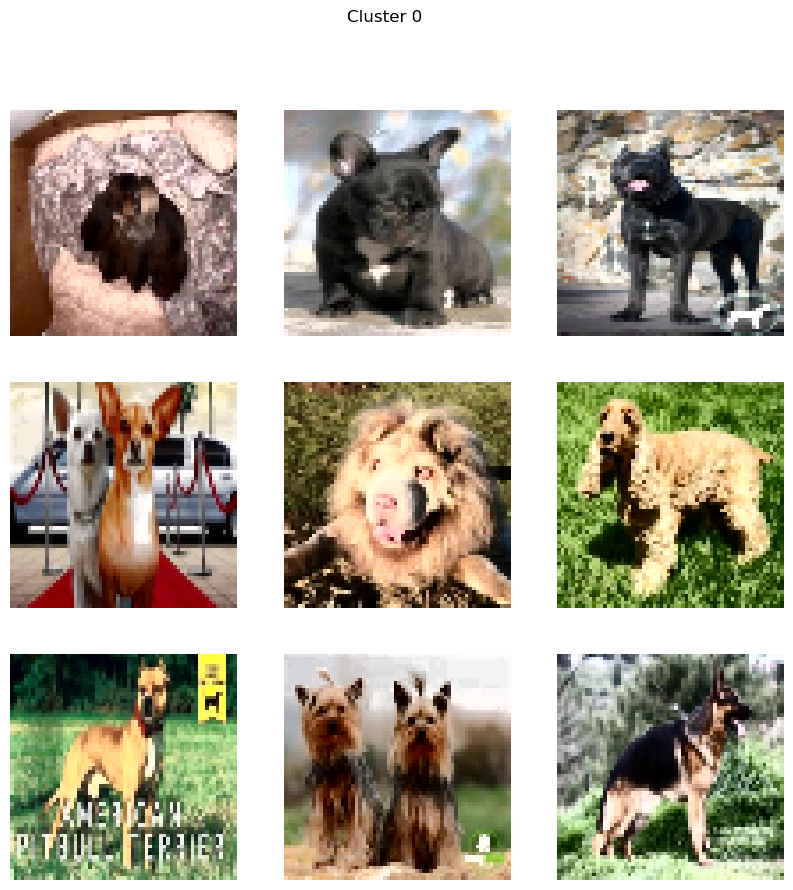

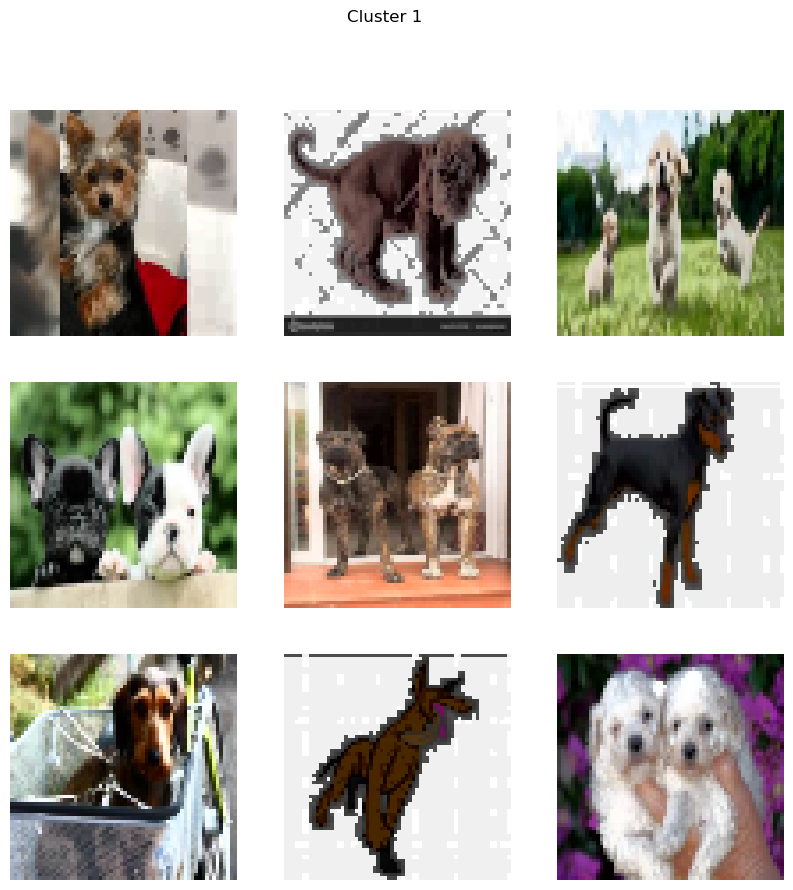

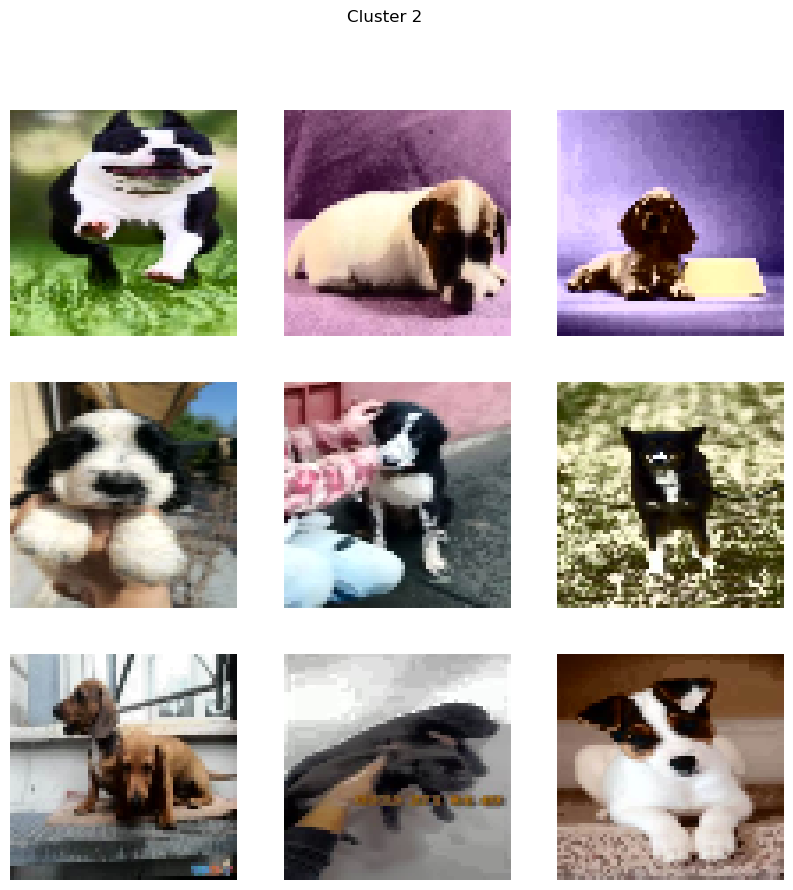

Visualizing clusters for category: gato


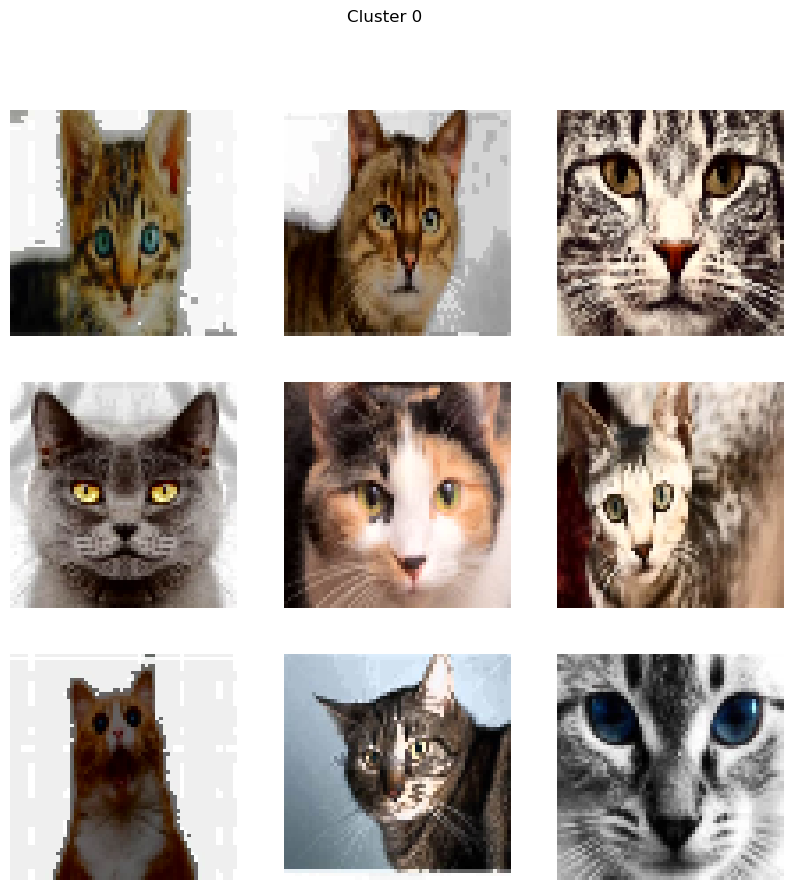

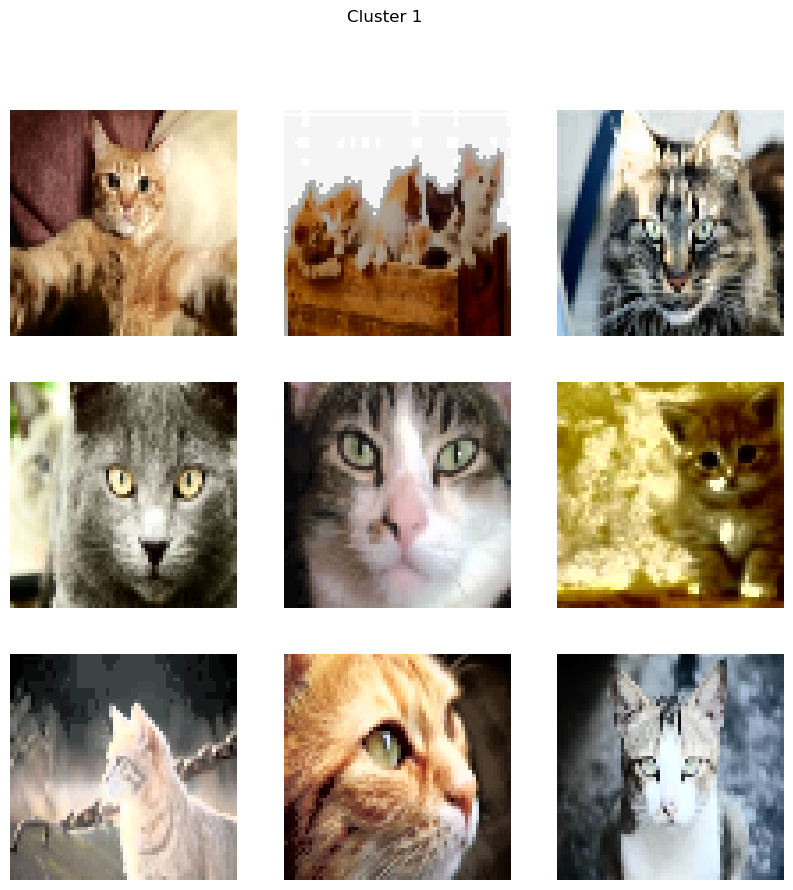

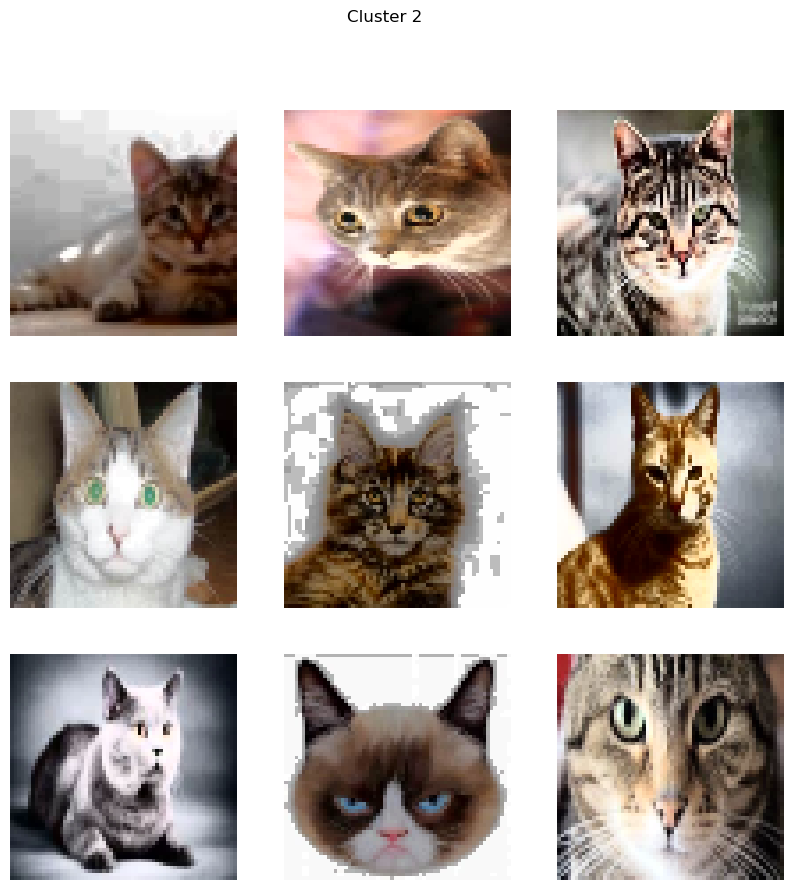

Visualizing clusters for category: gallina


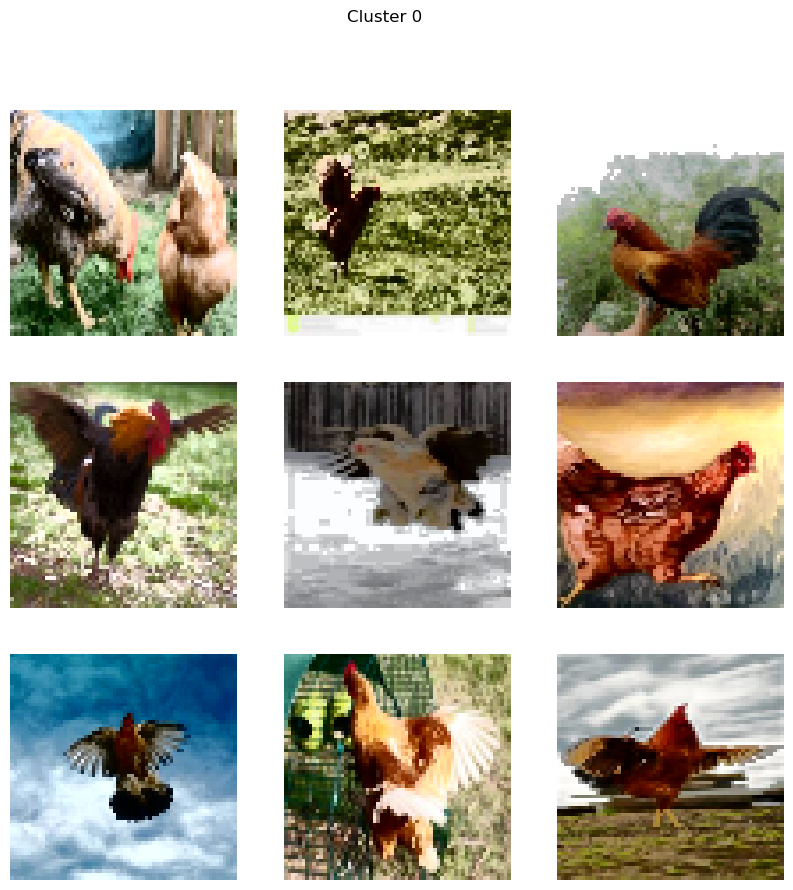

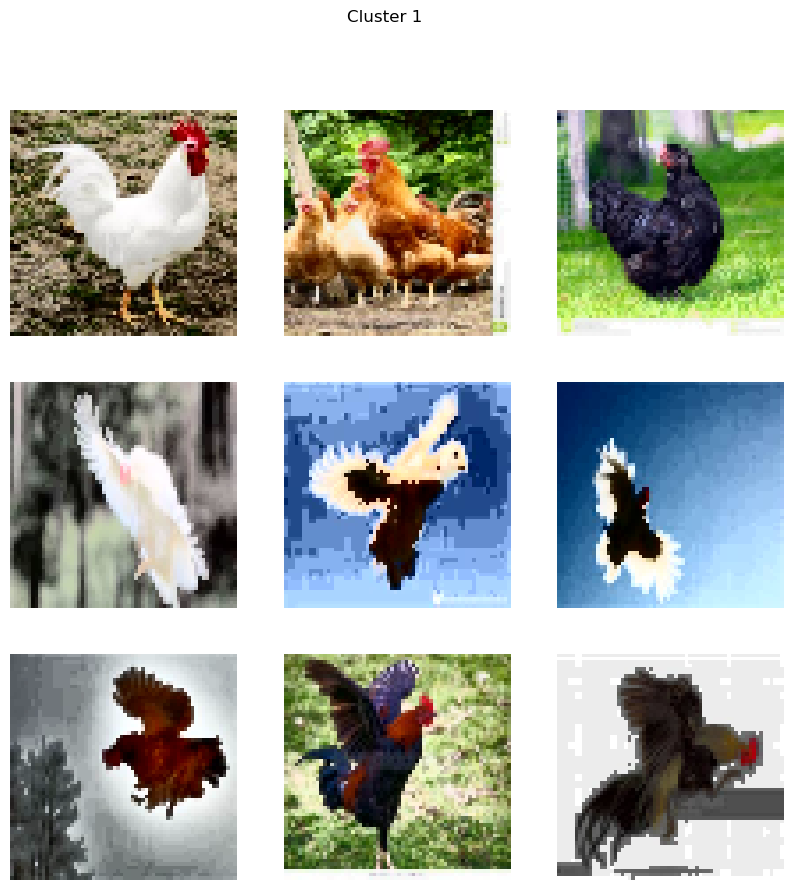

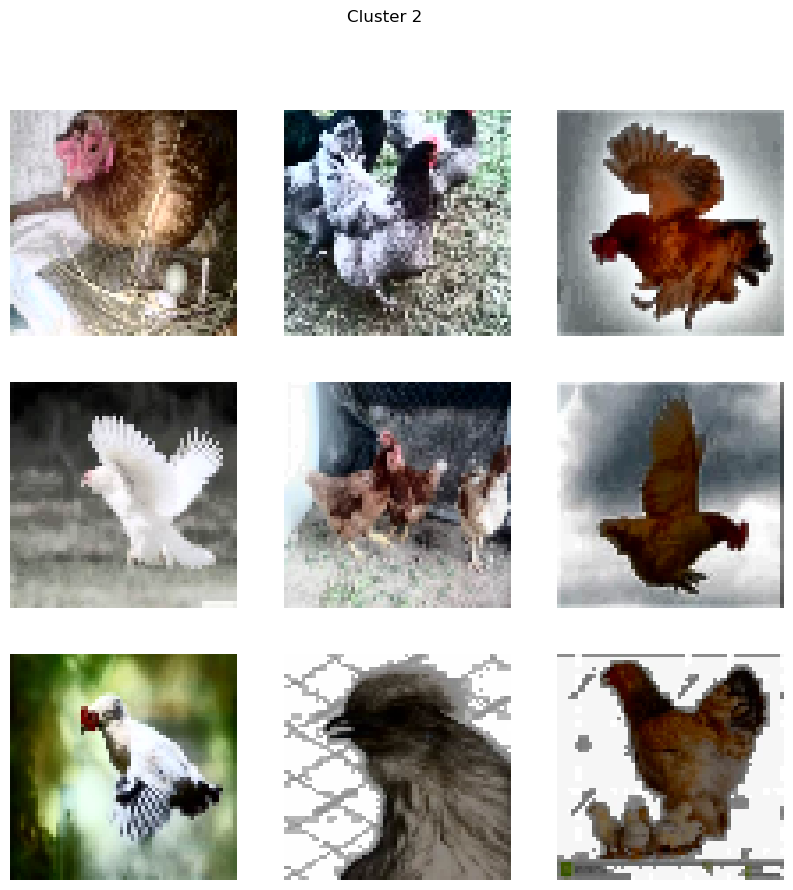

Aplicación de K-means completada.


In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(reduced_features)
labels_kmeans = kmeans.labels_

silhouette_avg = silhouette_score(reduced_features, labels_kmeans)
print(f"Silhouette Score: {silhouette_avg}")

def visualize_clusters(images, labels, n_clusters=3):
    for i in range(n_clusters):
        cluster = np.where(labels == i)[0]
        plt.figure(figsize=(10, 10))
        for j in range(min(len(cluster), 9)):
            plt.subplot(3, 3, j+1)
            plt.imshow(cv2.cvtColor(images[cluster[j]], cv2.COLOR_BGR2RGB))
            plt.axis('off')
        plt.suptitle(f'Cluster {i}')
        plt.show()

for category in categories:
    print(f'Visualizing clusters for category: {category}')
    visualize_clusters(preprocessed_images[category], labels_kmeans, n_clusters=n_clusters)

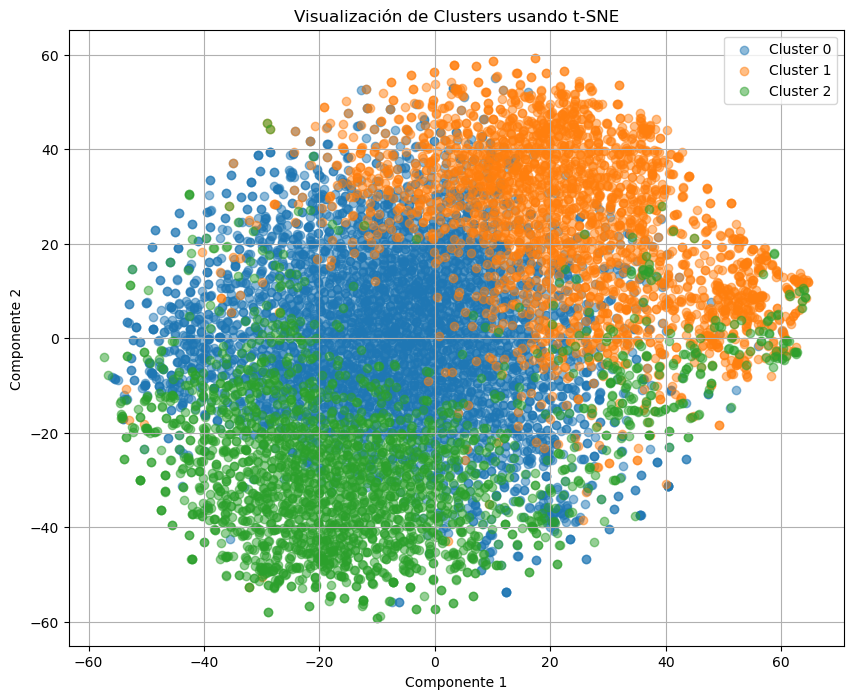

In [13]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
reduced_features_2d = tsne.fit_transform(reduced_features)

plt.figure(figsize=(10, 8))
for i in range(n_clusters):
    plt.scatter(reduced_features_2d[labels_kmeans == i, 0], reduced_features_2d[labels_kmeans == i, 1], label=f'Cluster {i}', alpha=0.5)
plt.title('Visualización de Clusters usando t-SNE')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend()
plt.grid()
plt.show()

In [14]:
from sklearn.model_selection import train_test_split

X = reduced_features
y = labels_kmeans 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)

y_pred = svm_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.9854620976116303
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1384
           1       0.99      0.98      0.98       798
           2       0.99      0.98      0.99       707

    accuracy                           0.99      2889
   macro avg       0.99      0.98      0.99      2889
weighted avg       0.99      0.99      0.99      2889

Confusion Matrix:
[[1369   10    5]
 [  12  783    3]
 [  11    1  695]]
